In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel
from sklearn.model_selection import KFold
import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.integrate import quad
from astropy.constants import c
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV

plt.rc('text', usetex=True) 
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'


# Data Driven part
First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

(35.0, 50.0)

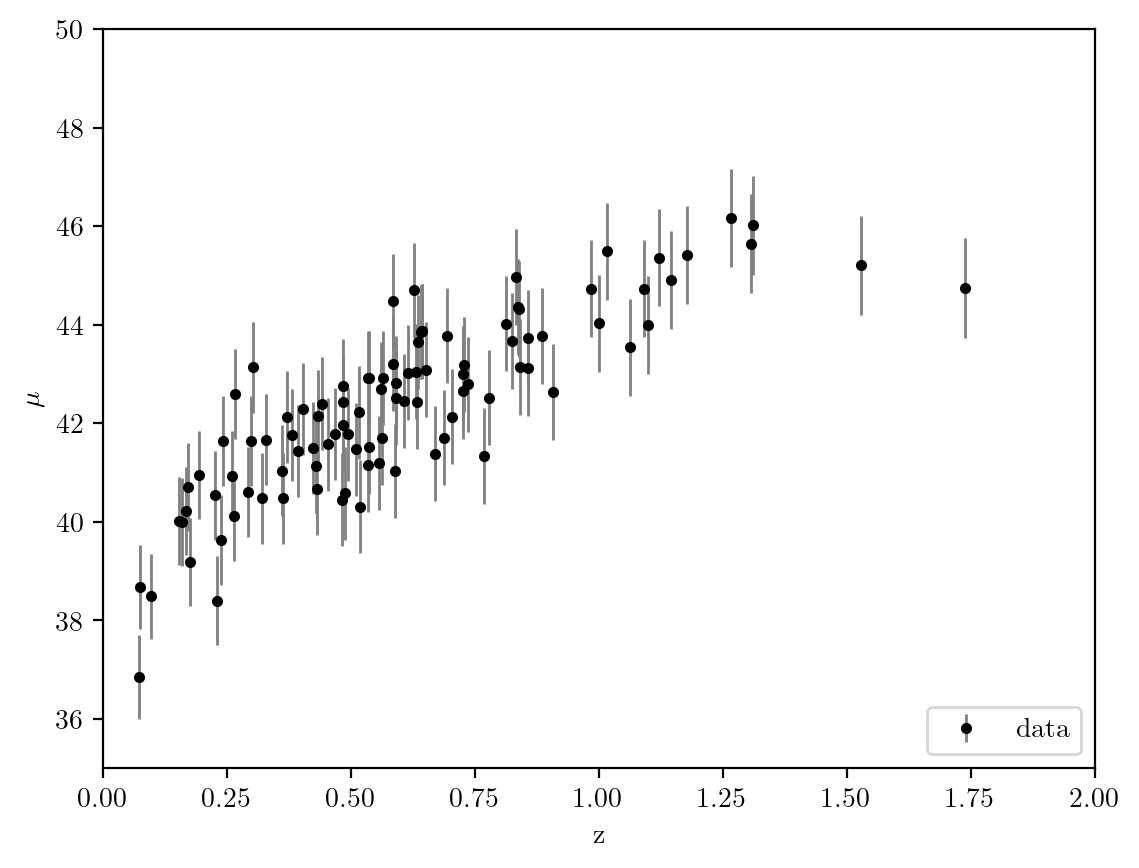

In [4]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## GPR

try with two kernels

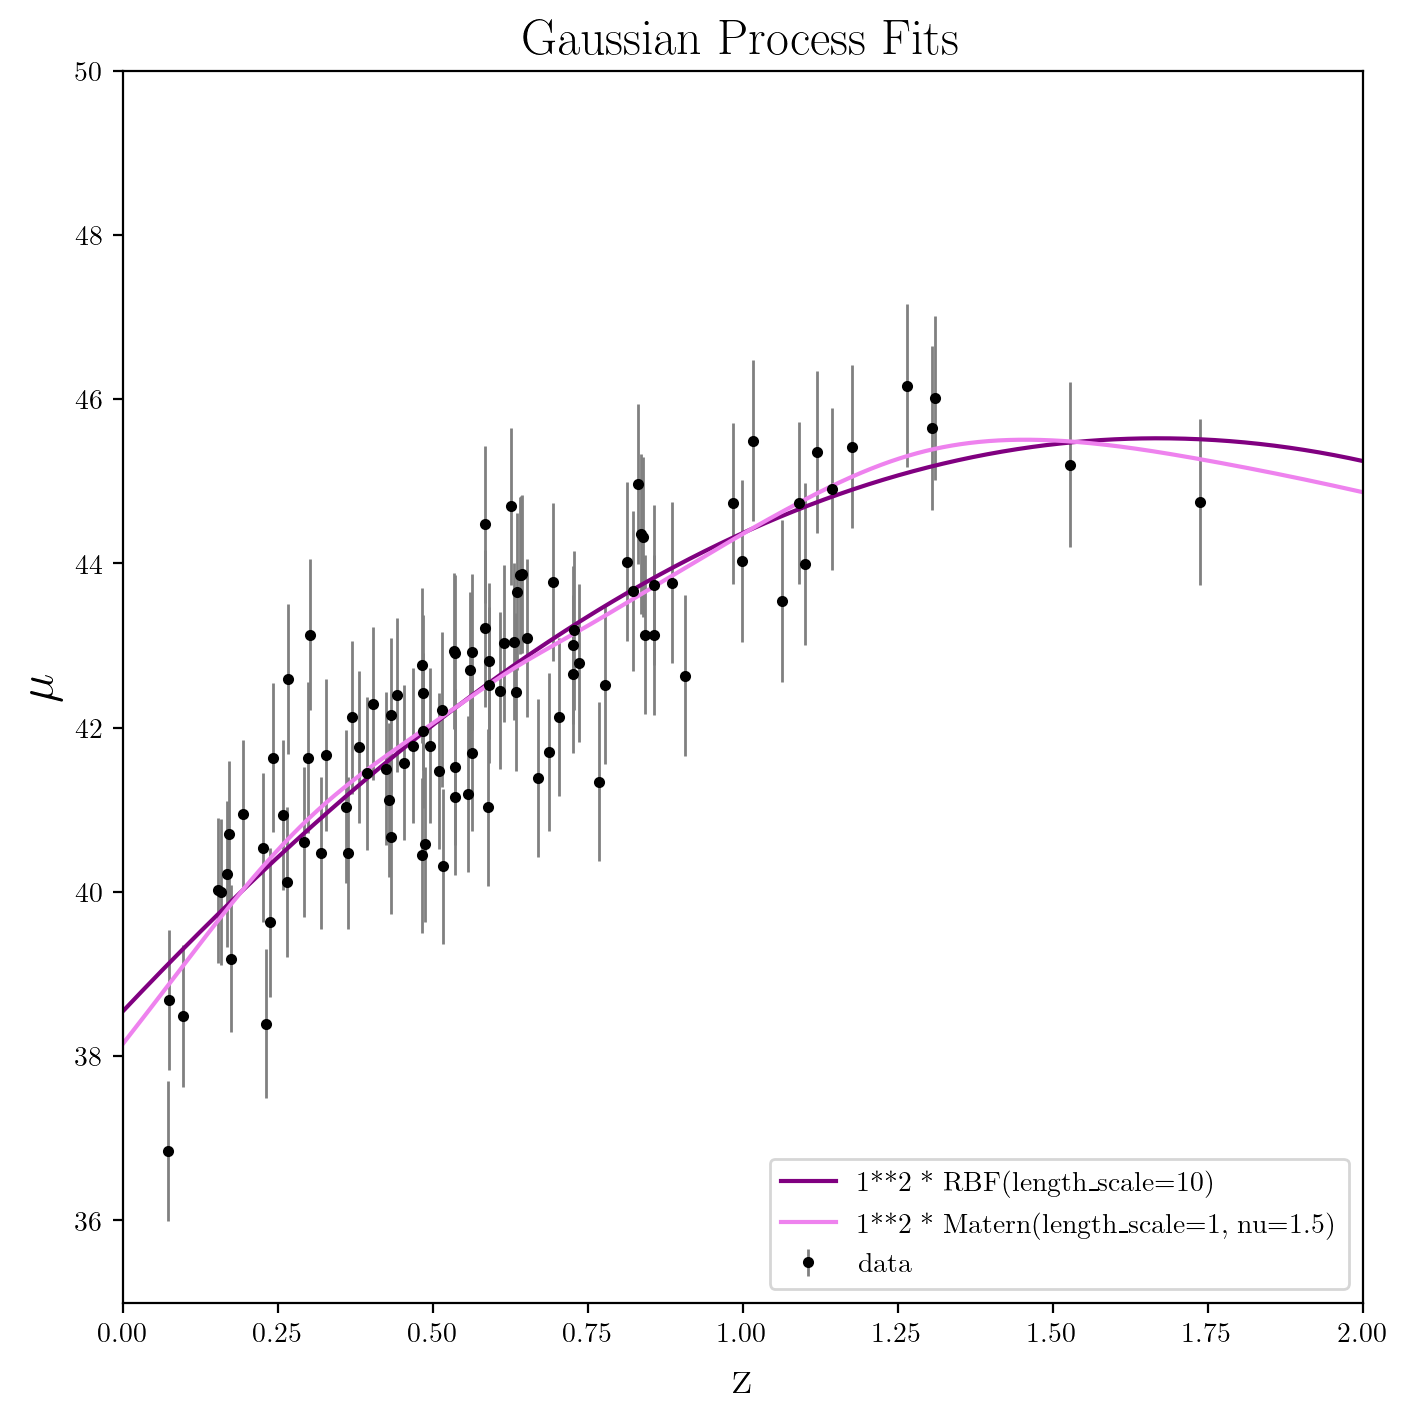

In [28]:
alpha = dmu ** 2 #errors from std to variance to be included in the fit
z_fit = np.linspace(0,2,1000)

kernels = [
    ConstantKernel(1.0) * RBF(length_scale=10),
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
]

plt.figure(figsize=(8, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

colors = ['purple', 'violet']

for kernel, c in zip(kernels, colors):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp.fit(z_sample.reshape(-1, 1), mu_sample)
    mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)

    plt.plot(z_fit, mu_pred, label=f'{kernel}', color=c)

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Gaussian Process Fits', fontsize=18)
plt.show()

## K-fold Cross Validation on RBF 

In [29]:
#two hyperpar to tune: the costant in front and the lenght scale
constants = np.geomspace(0.1, 100, 20)
scales = np.linspace(1, 100, 40)

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        fold_errors = []
        
        for train_idx, val_idx in kf.split(z_sample):
            z_train, z_val = z_sample[train_idx], z_sample[val_idx]
            mu_train, mu_val = mu_sample[train_idx], mu_sample[val_idx]
            dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]
            
            kernel = ConstantKernel(c) * RBF(length_scale=ls)
            gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
            gp.fit(z_train.reshape(-1, 1), mu_train)
            
            mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
            
            error = np.sqrt(np.mean((mu_pred - mu_val) ** 2))
            fold_errors.append(error)
        
        crossval_err.append((c, ls, np.mean(fold_errors)))
        
best_kernel_params = min(crossval_err, key=lambda x: x[2])
print(f"Best kernel parameters: Constant {best_kernel_params[0]}, Length Scale {best_kernel_params[1]} with error {best_kernel_params[2]:.4f}")


Best kernel parameters: Constant 3.79269019073225, Length Scale 1.0 with error 0.9331


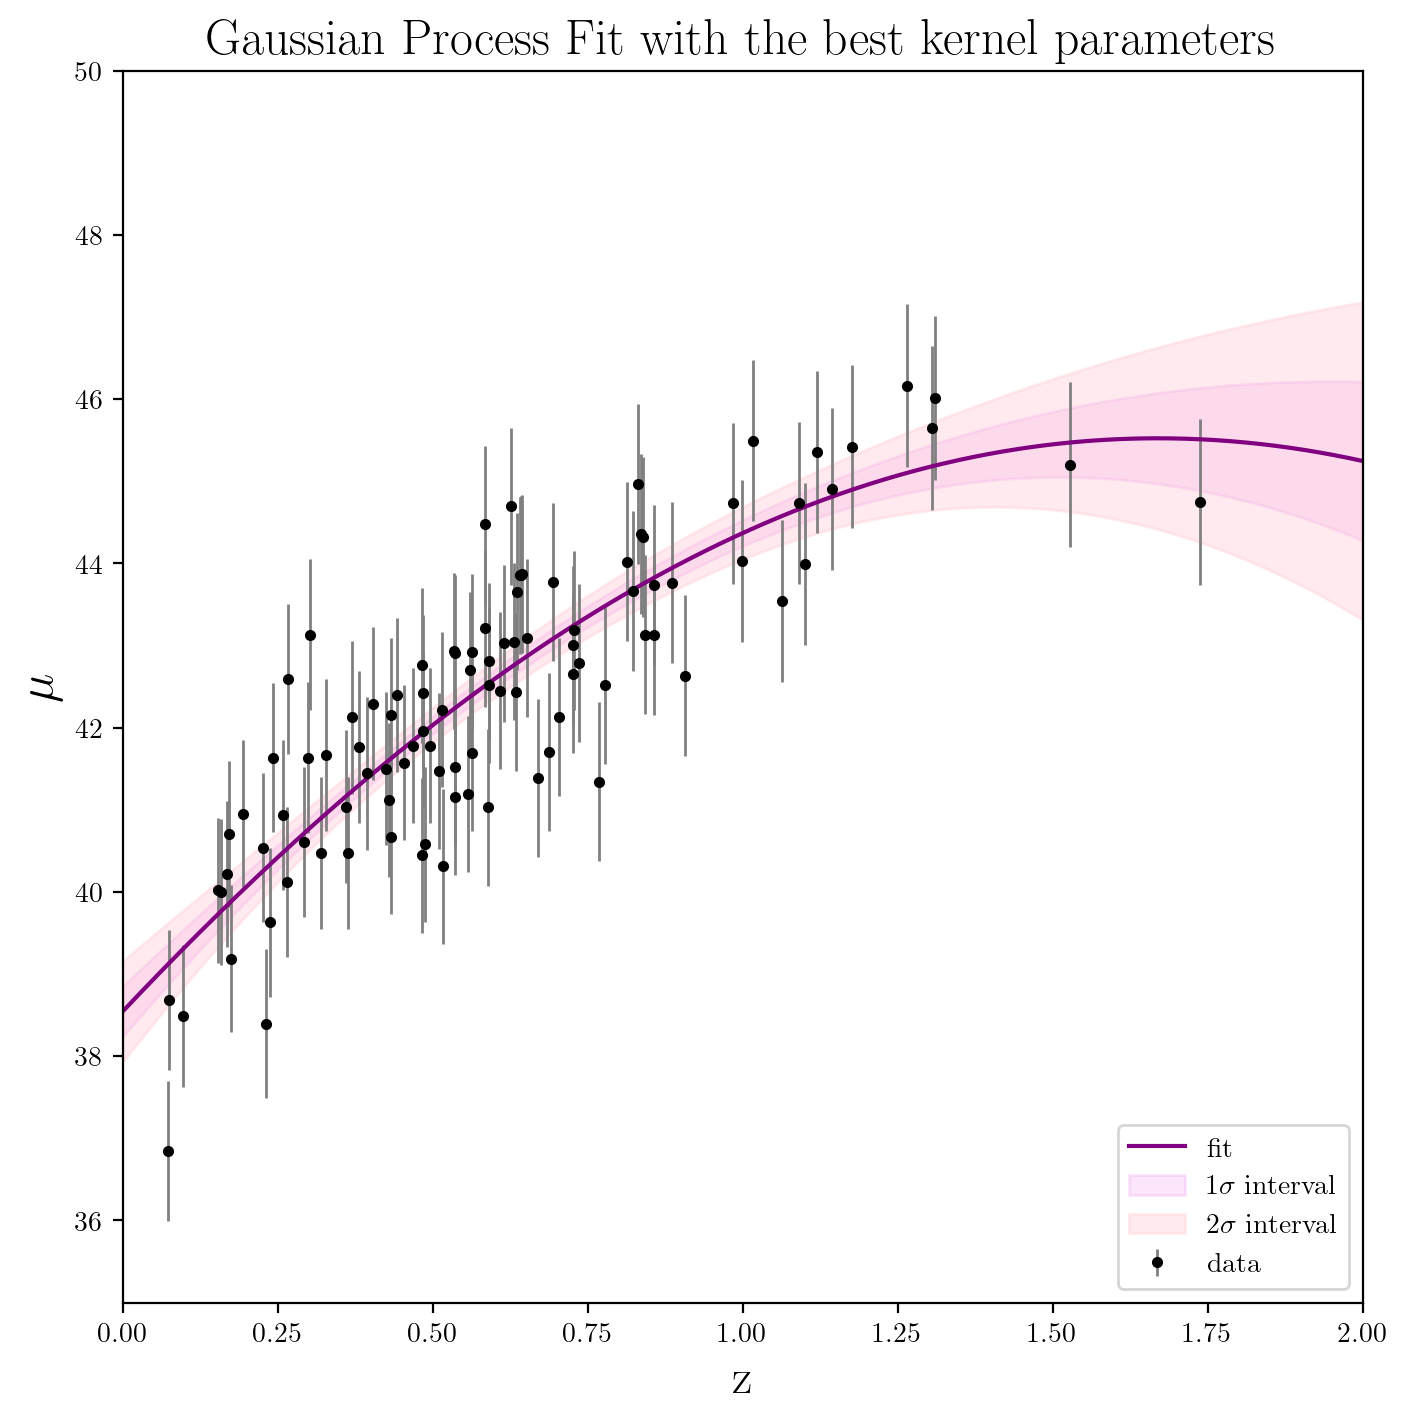

In [30]:
kernel = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
gp.fit(z_sample.reshape(-1, 1), mu_sample)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)


plt.figure(figsize=(8, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit', color='purple')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval', color='violet')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.3, label='2$\sigma$ interval', color='pink')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

## K-fold cross validation on Matern

In [26]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
constants = np.geomspace(0.1, 100, 20)
np.linspace(0.1, 50, 35)
nu = [0.2,1.5,2.5]

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        for n in nu:
                
            fold_errors = []
            
            for train_idx, val_idx in kf.split(z_sample):
                z_train, z_val = z_sample[train_idx], z_sample[val_idx]
                mu_train, mu_val = mu_sample[train_idx], mu_sample[val_idx]
                dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]
                
                kernel = ConstantKernel(c) * Matern(length_scale=ls, nu=n)
                gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
                gp.fit(z_train.reshape(-1, 1), mu_train)
                
                mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
                
                error = np.sqrt(np.mean((mu_pred - mu_val) ** 2))
                fold_errors.append(error)
            
            crossval_err.append((c, ls, np.mean(fold_errors)))

best_kernel_params_2 = min(crossval_err, key=lambda x: x[2])
print(f"Best kernel parameters: Constant {best_kernel_params_2[0]}, Length Scale {best_kernel_params_2[1]} , Nu {best_kernel_params_2[2]:.4f}")


Best kernel parameters: Constant 23.357214690901213, Length Scale 34.0 , Nu 0.9253


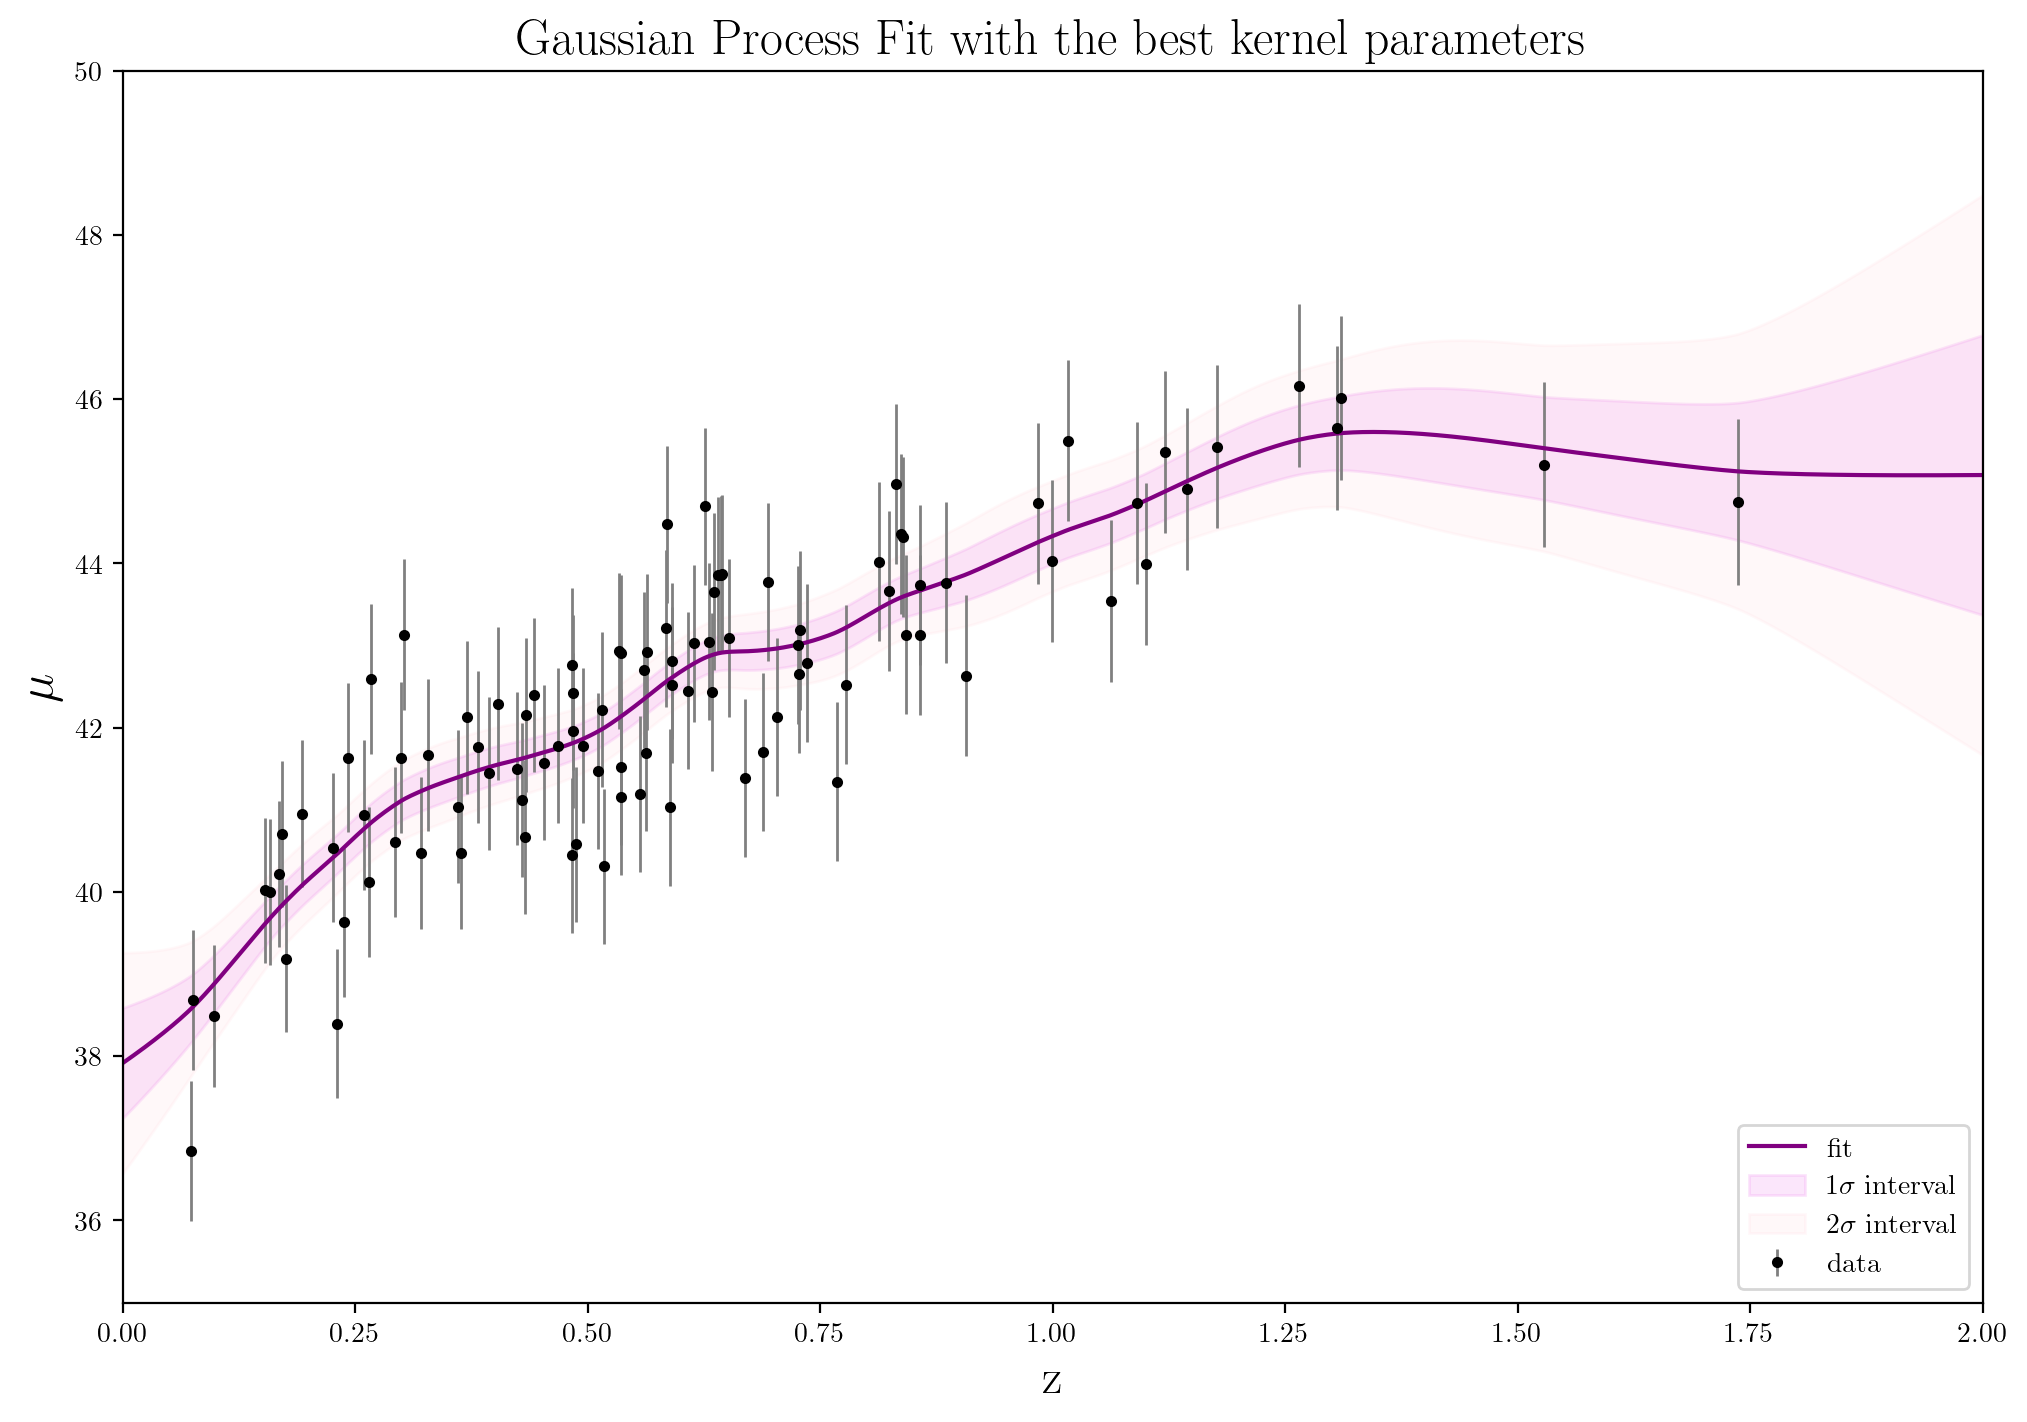

In [27]:
kernel = ConstantKernel(best_kernel_params_2[0]) * Matern(length_scale=best_kernel_params_2[1], nu=best_kernel_params_2[2])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
gp.fit(z_sample.reshape(-1, 1), mu_sample)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)


plt.figure(figsize=(12, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit', color='purple')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval', color='violet')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.1, label='2$\sigma$ interval', color='pink')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

# Parametric Fit
- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

#### My computation
Let's assume curvature equal 0, so $\Omega_K$ = 0
1. $$\mu = 5 \log \left(\frac{D_L}{10pc}\right) $$

2. $$ D_L = (1+z)D_C $$

3. $$  D_C = c/H_0 \int _0 ^z \frac{dz'}{E(z')} = c/H_0 \int _0 ^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3+\Omega_\Lambda}}$$

4. $$ \Omega_\Lambda = 1 - \Omega_m  $$

so the 1st equation become 
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z')^3+(1-\Omega_m)}} \right) $$



Run nested sampling to fit and compare

In [36]:
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from scipy.stats import norm

cosmology = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [39]:
def mu_cosmology(z, H0 ,om):
    cosmology = FlatLambdaCDM(H0=H0, Om0=om, Tcmb0=2.725)
    return cosmology.distmod(z).value

def loglike(params):
    H0, om = params
    if om > 0:
        mu = mu_cosmology(z_sample, H0, om)
        return np.sum(norm(loc=mu, scale=dmu).logpdf(mu_sample))
    if om < 0:
        return -np.inf
        
def nest_flat_prior(u, min_val, max_val):
    # `u` between 0 e 1 transform in space par
    return min_val + u * (max_val - min_val)

def prior_transform(u):
    H0 = nest_flat_prior(u[0], 35, 95)
    om  = nest_flat_prior(u[1], 0, 1)
    
    return [H0, om]
    

In [46]:
ndim = 2
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=500) 
sampler.run_nested()
sresults = sampler.results

1617it [00:34, 47.55it/s, +500 | bound: 0 | nc: 1 | ncall: 13340 | eff(%): 16.488 | loglstar:   -inf < -132.815 <    inf | logz: -135.188 +/-  0.046 | dlogz:  0.001 >  0.509]


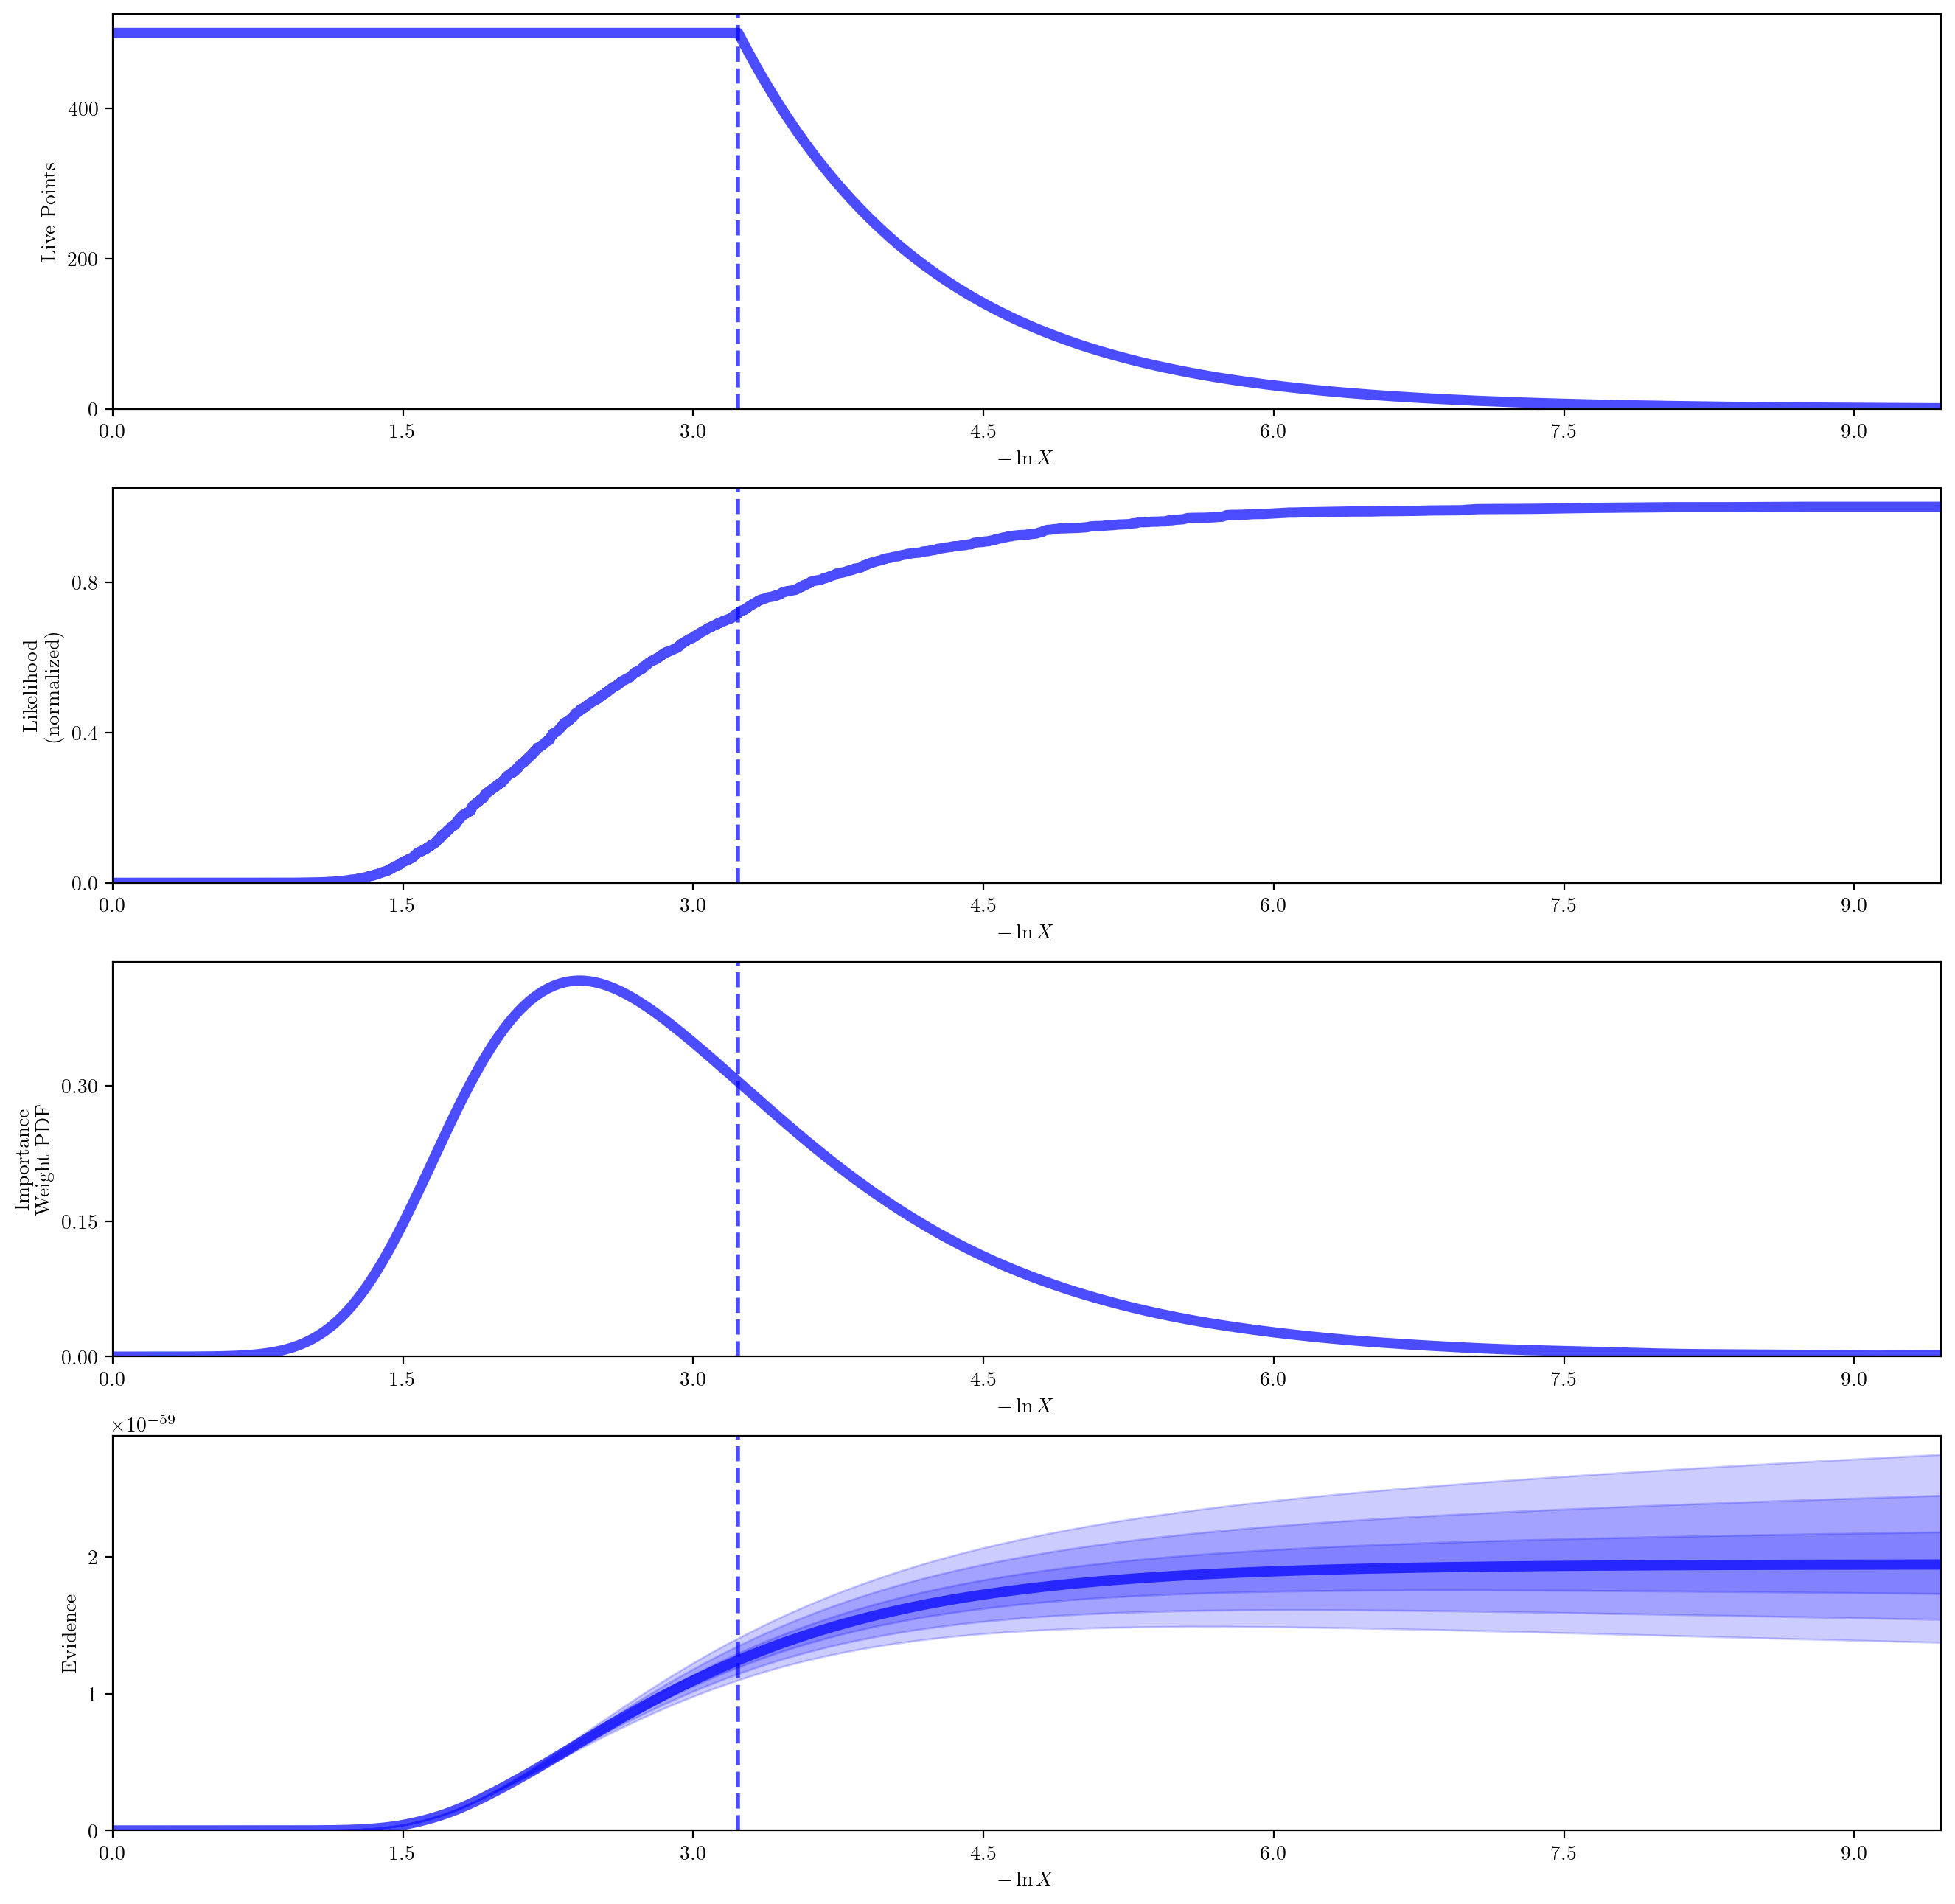

In [47]:
rfig, raxes = dyplot.runplot(sresults)

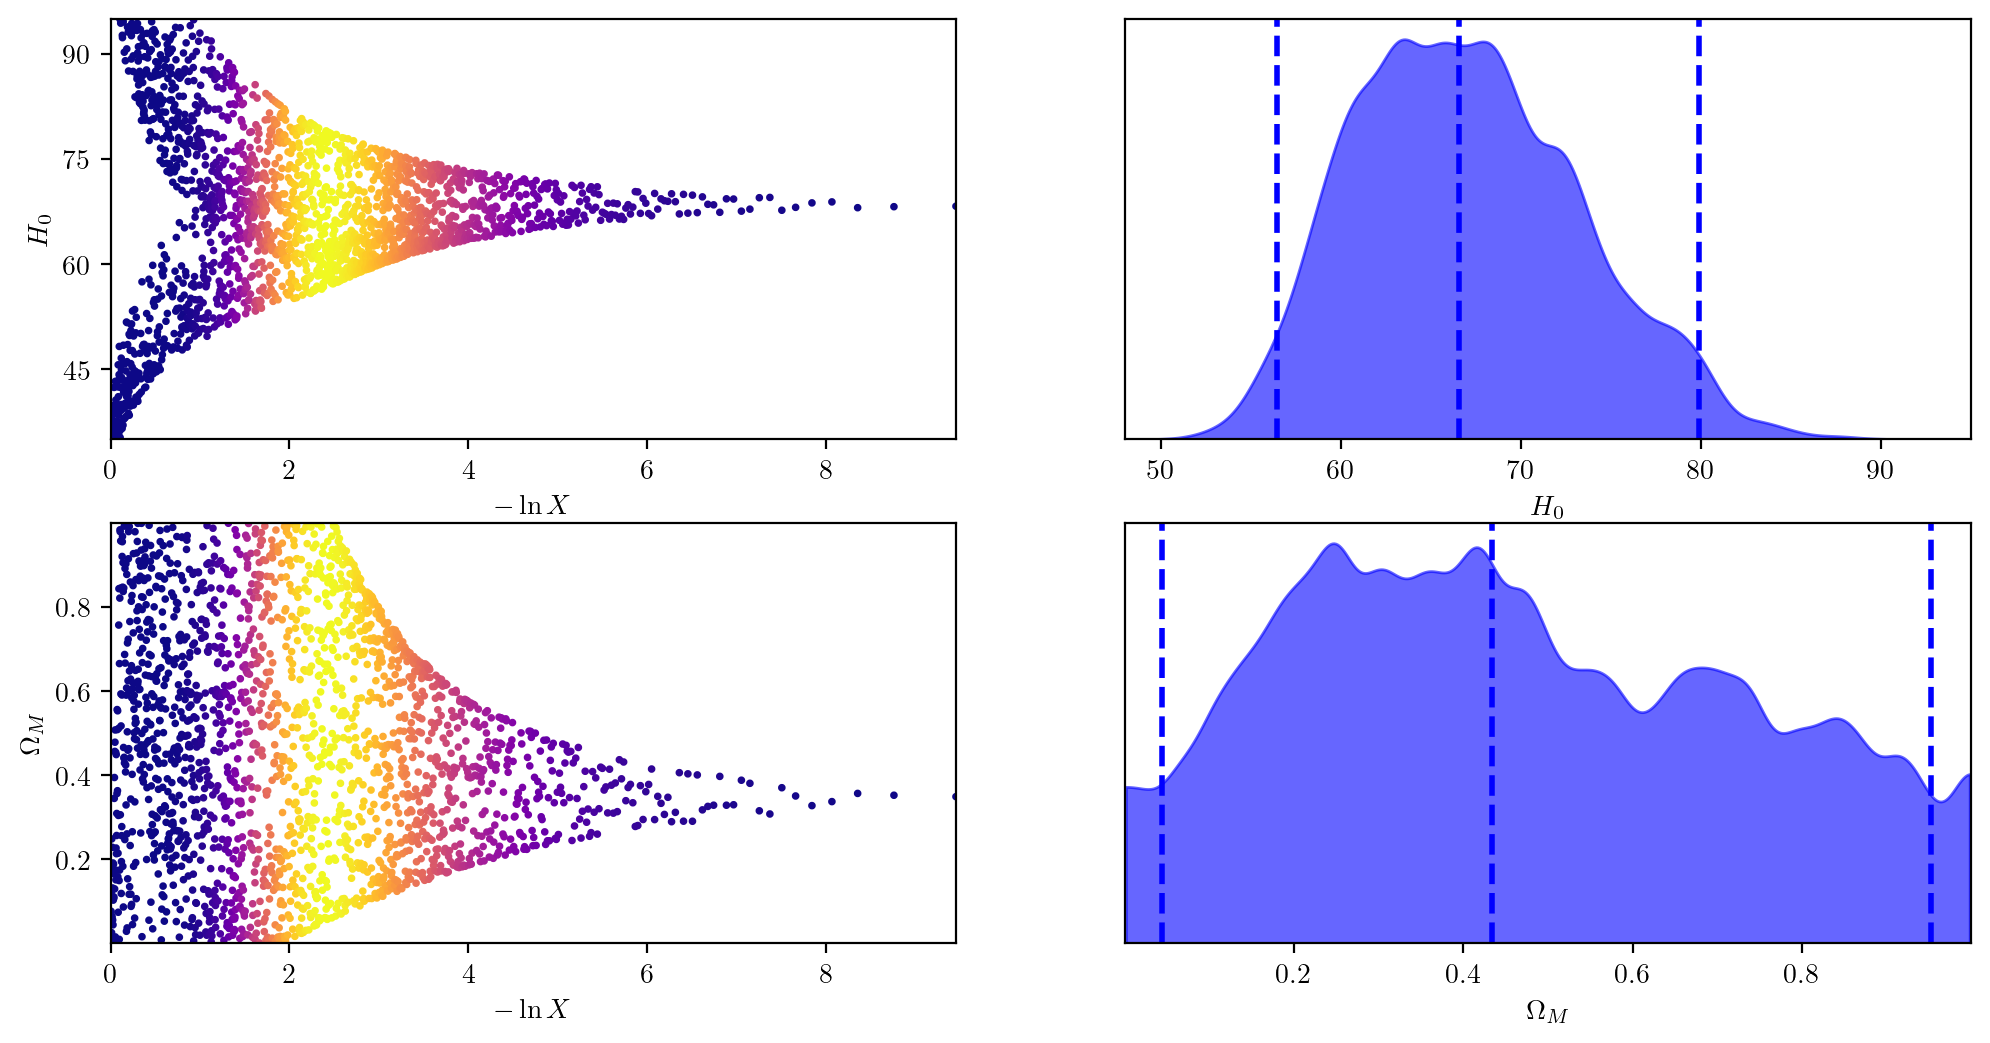

In [48]:
labels = [r'$H_0$', r'$\Omega_M$']
tfig, taxes = dyplot.traceplot(sresults, labels=labels)

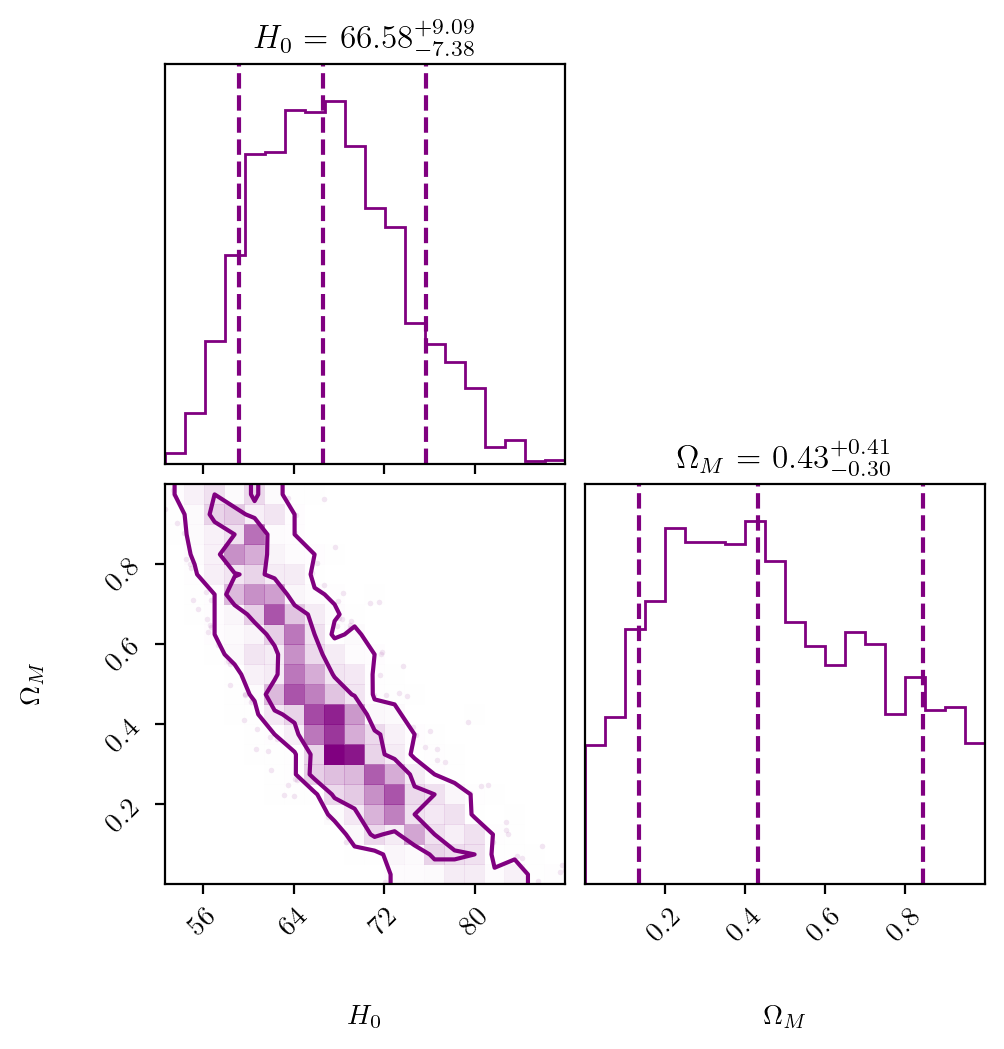

In [49]:
samples = sresults.samples  
weights = np.exp(sresults.logwt - sresults.logz[-1])

samples_equal = dyfunc.resample_equal(samples, weights)

fig = corner.corner(
    samples_equal,                      
    labels=labels,                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='purple'                           
)

fig.show()

/home/ludovicarbone/astrostat_env/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


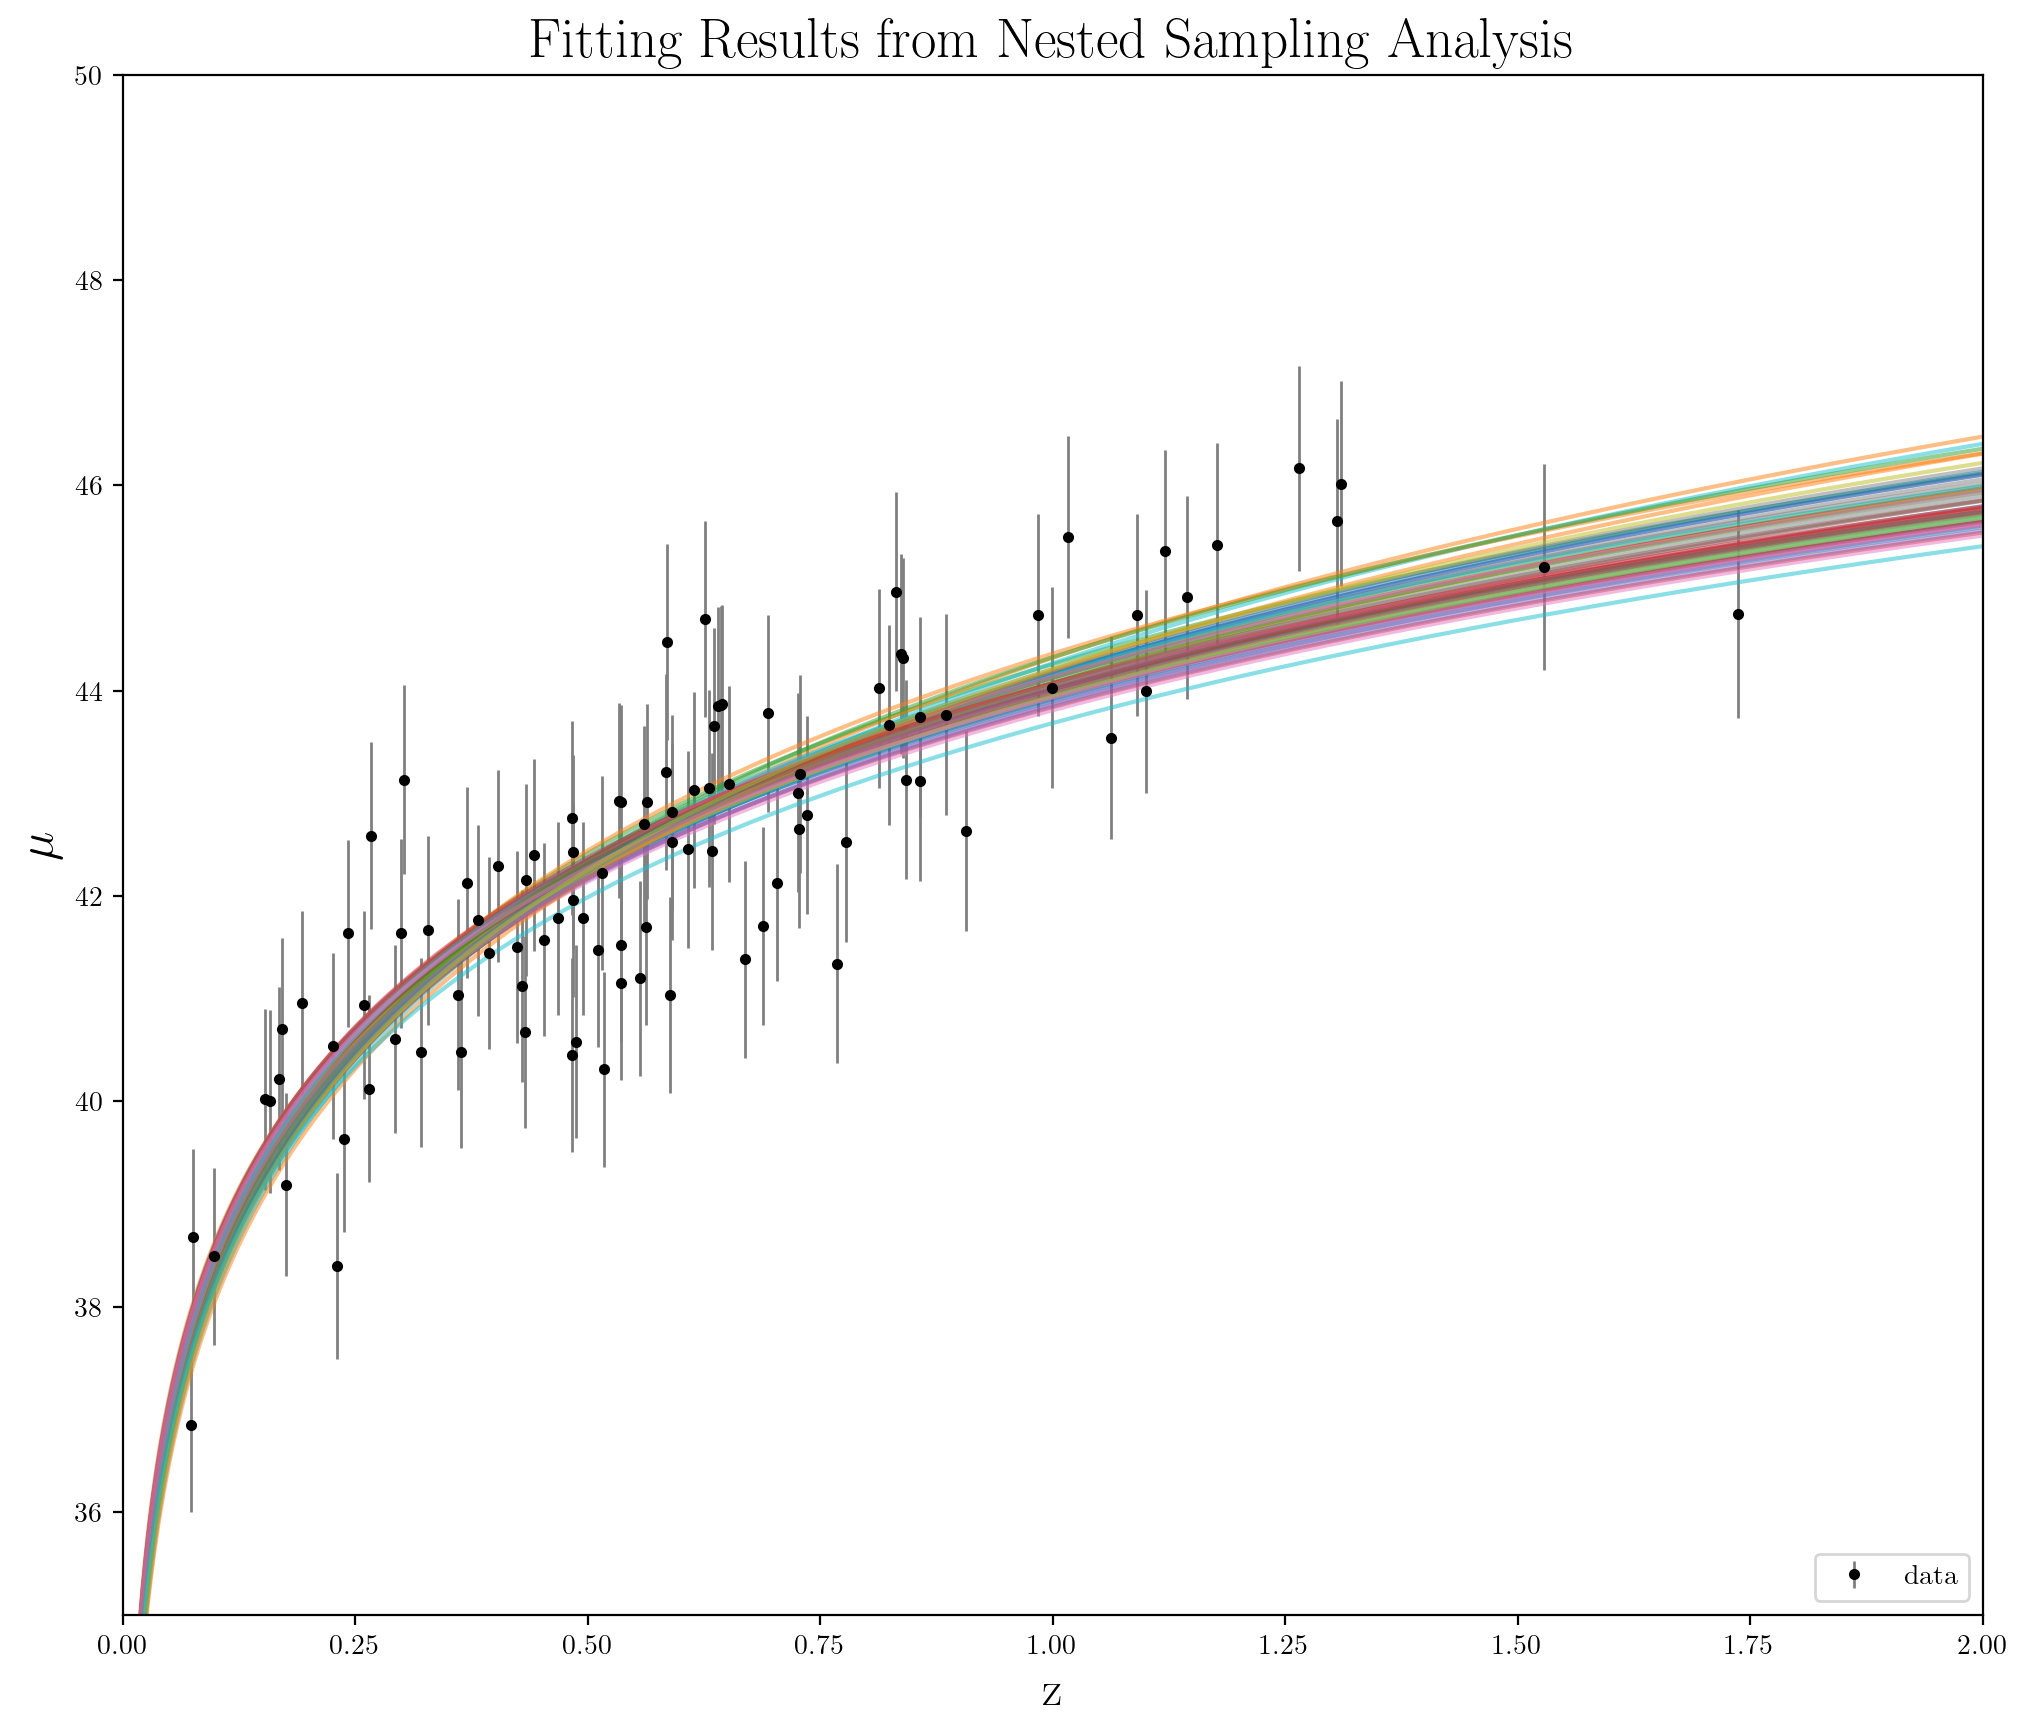

In [73]:
fig = plt.figure(figsize=(12, 10))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

samples_batch = np.random.choice(np.arange(0, len(samples_equal)), size=50, replace=False)
chosen_samples= samples_equal[samples_batch]

for chosen_par in chosen_samples:
    H0, om = chosen_par
    ygrid =  mu_cosmology(z_fit, H0, om)
    plt.plot(z_fit, ygrid, alpha=0.5)
    
plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Fitting Results from Nested Sampling Analysis', fontsize=20)
plt.show()

#### No Dark Energy model

In [65]:
def loglike_new(params):
    H0 = params[0]
    om = 1
    mu = mu_cosmology(z_sample, H0, om)
    return np.sum(norm(loc=mu, scale=dmu).logpdf(mu_sample))

def prior_transform_new(u):
    H0 = nest_flat_prior(u[0], 35, 95)
    
    return [H0]

In [66]:
ndim_new = 1
sampler_new = dynesty.NestedSampler(loglike_new, prior_transform_new, ndim_new) 
sampler_new.run_nested()
sresults_new = sampler_new.results

1630it [00:32, 50.87it/s, +500 | bound: 0 | nc: 1 | ncall: 12408 | eff(%): 17.887 | loglstar:   -inf < -133.531 <    inf | logz: -135.887 +/-  0.041 | dlogz:  0.001 >  0.509]


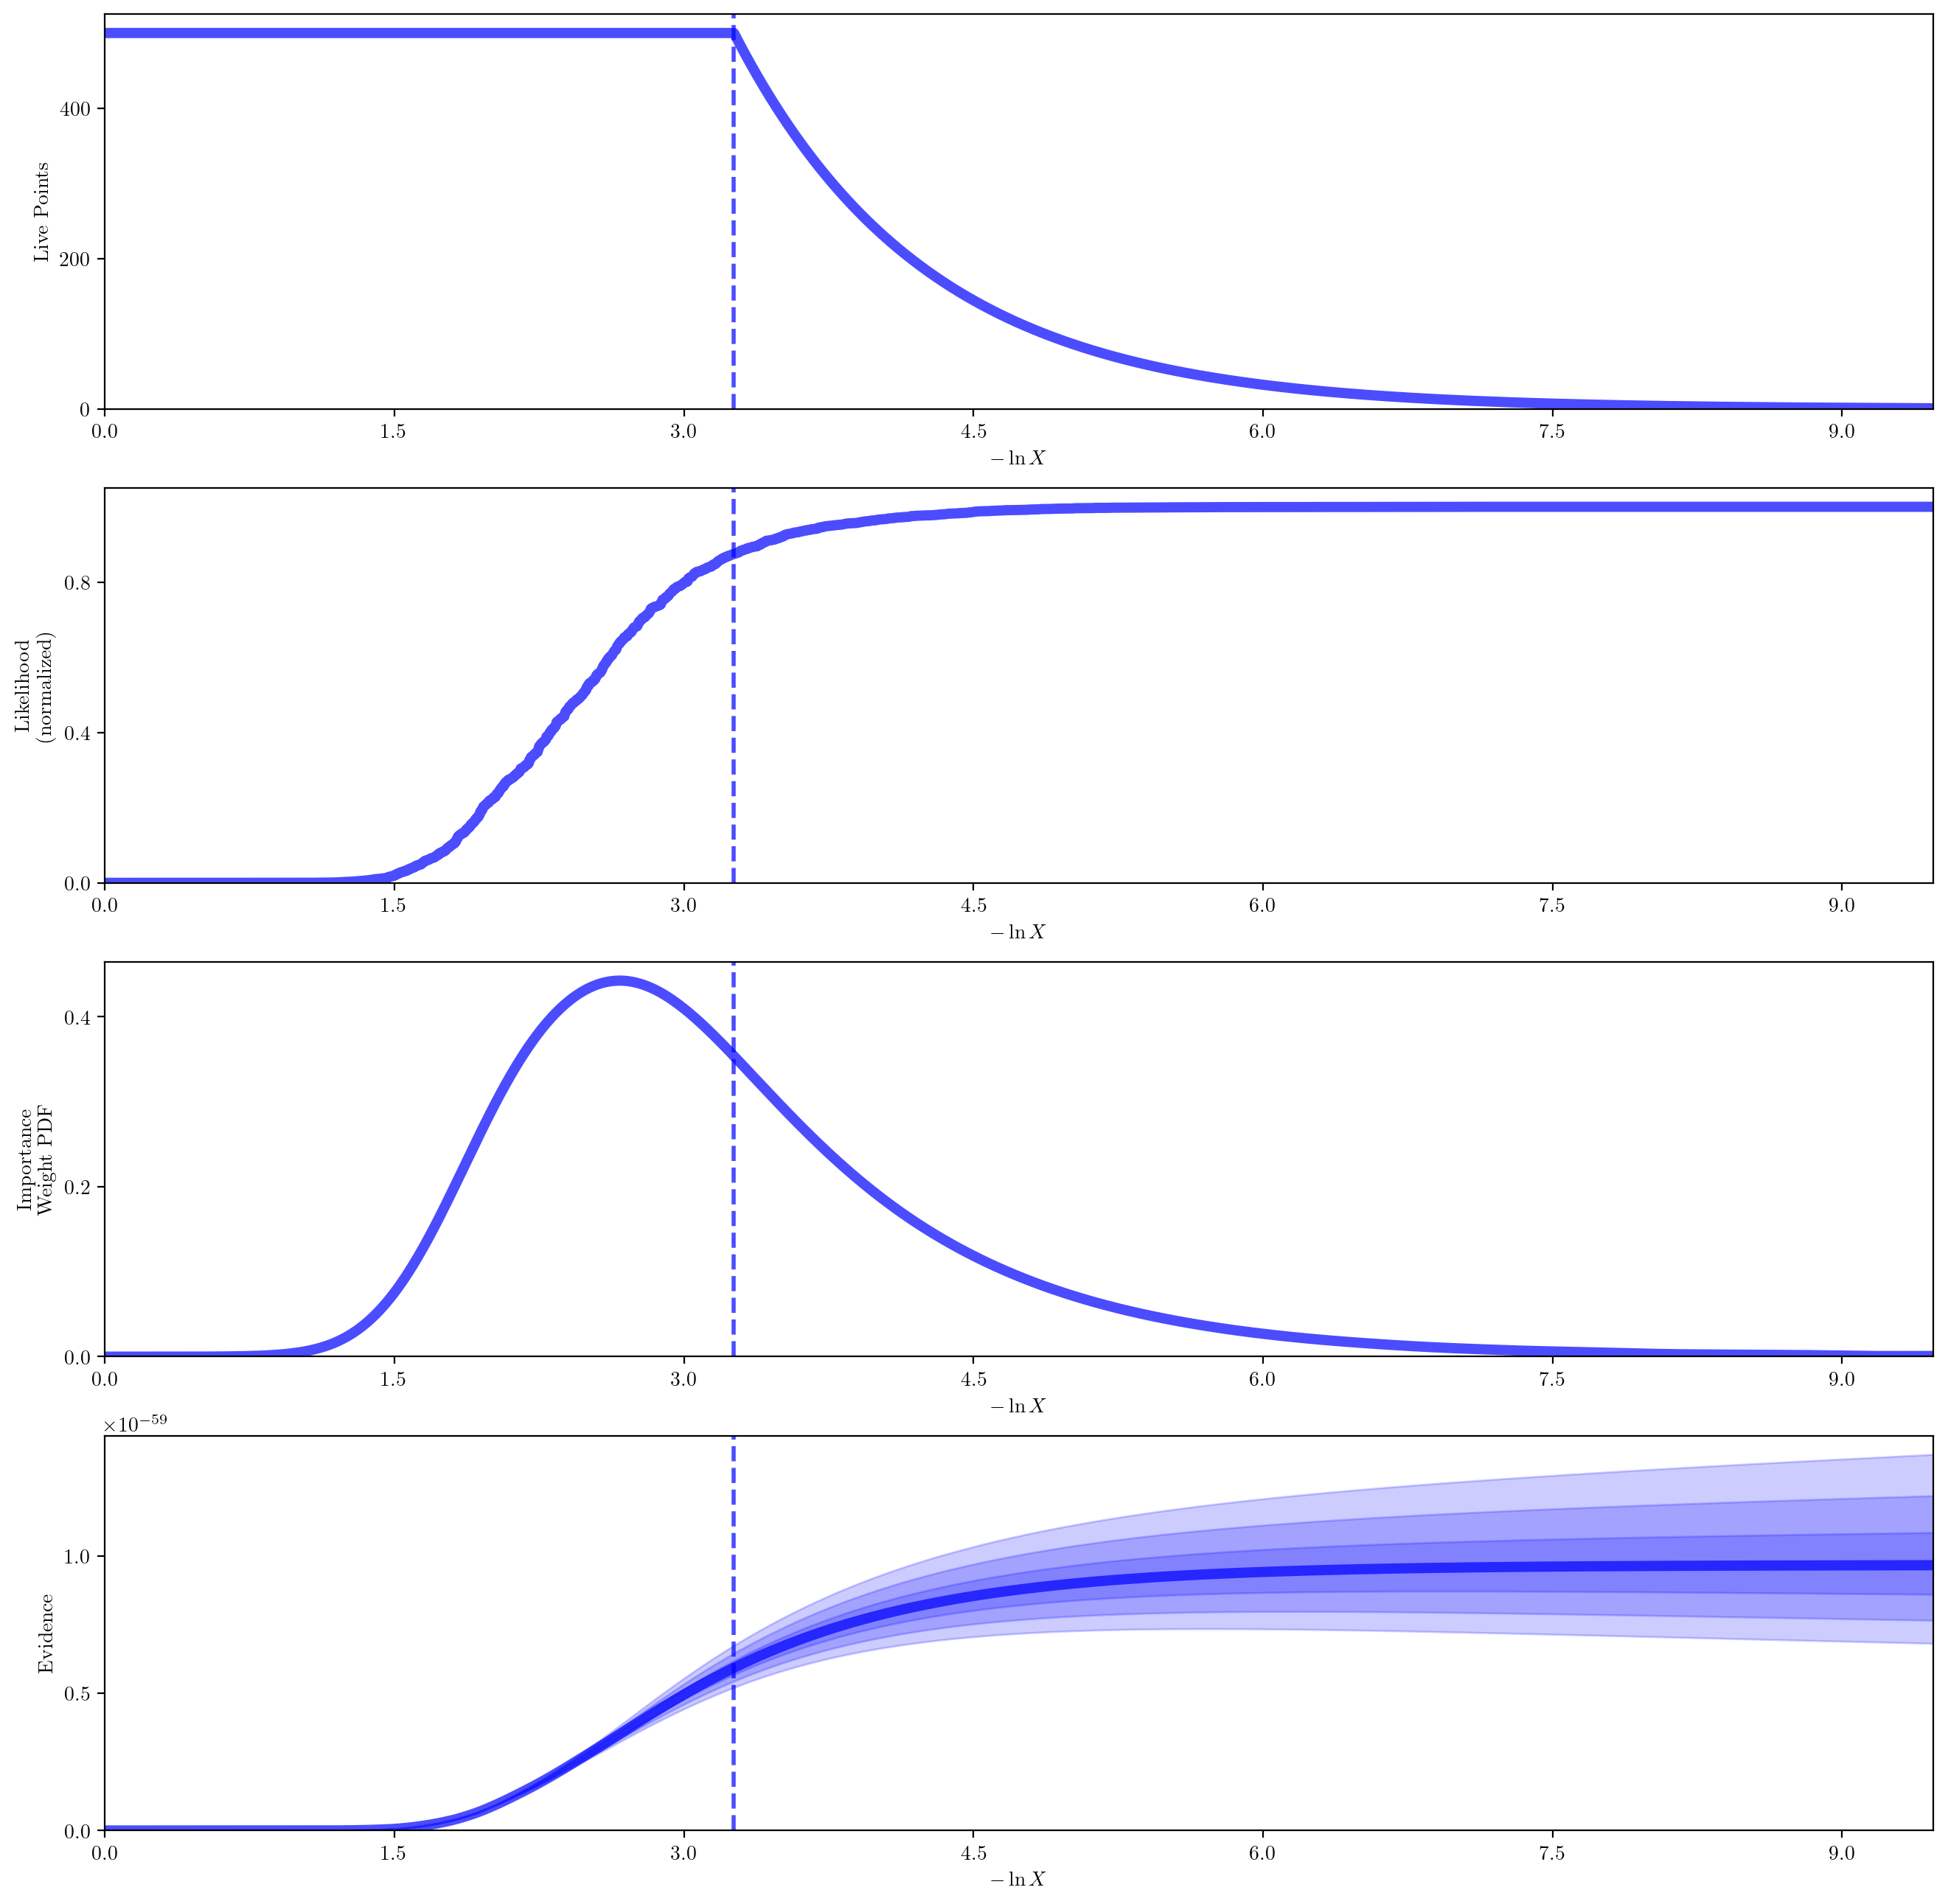

In [67]:
rfig, raxes = dyplot.runplot(sresults_new)

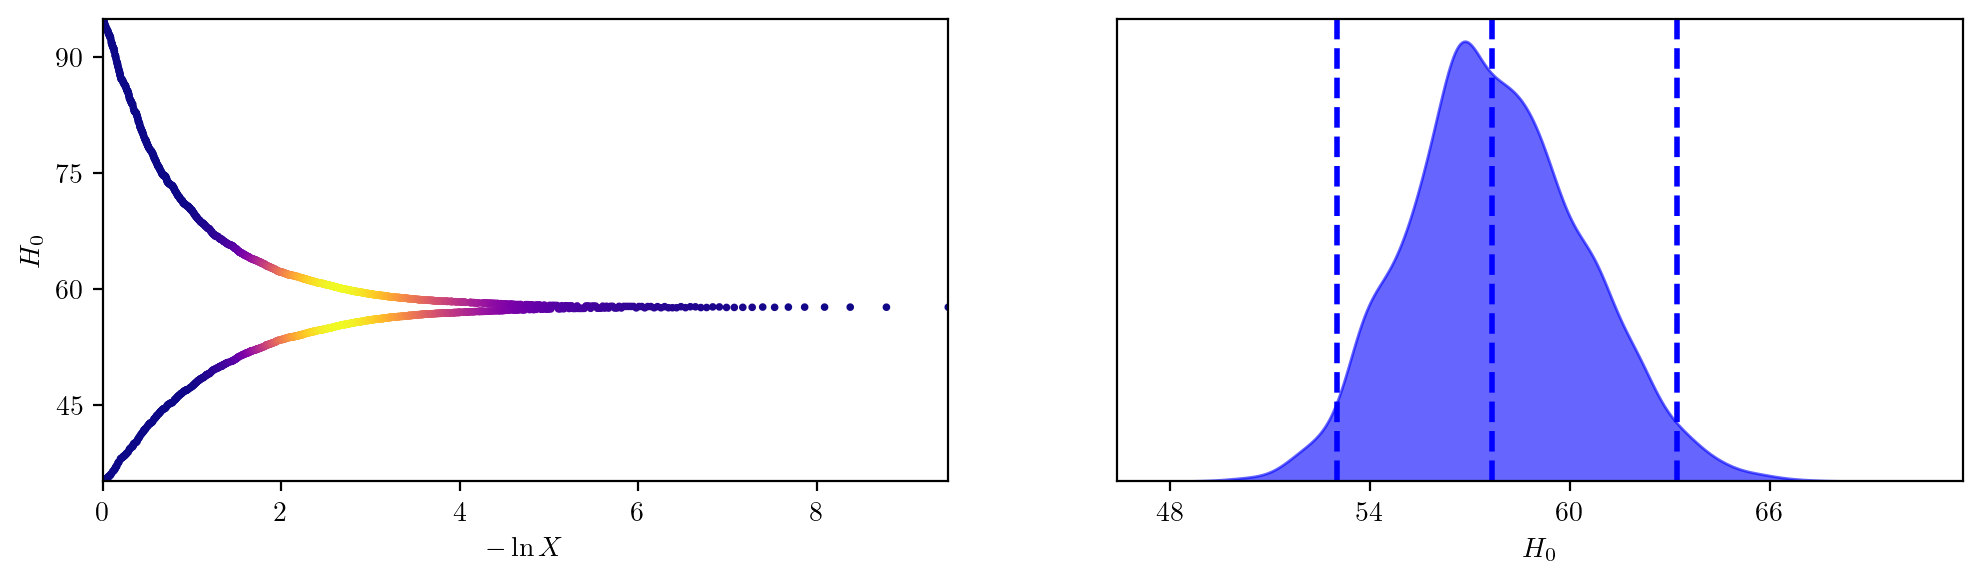

In [68]:
tfig, taxes = dyplot.traceplot(sresults_new, labels=[r'$H_0$'])

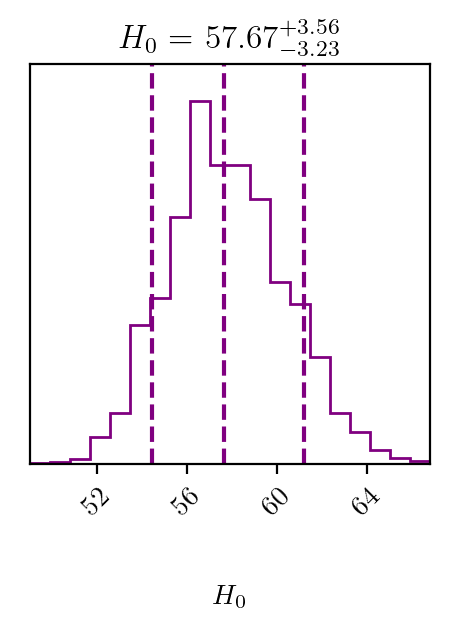

In [69]:
samples_new = sresults_new.samples  
weights_new = np.exp(sresults_new.logwt - sresults_new.logz[-1])

samples_equal_new = dyfunc.resample_equal(samples_new, weights_new)

fig = corner.corner(
    samples_equal_new,                      
    labels=[r'$H_0$'],                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='purple'                           
)

fig.show()

/home/ludovicarbone/astrostat_env/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


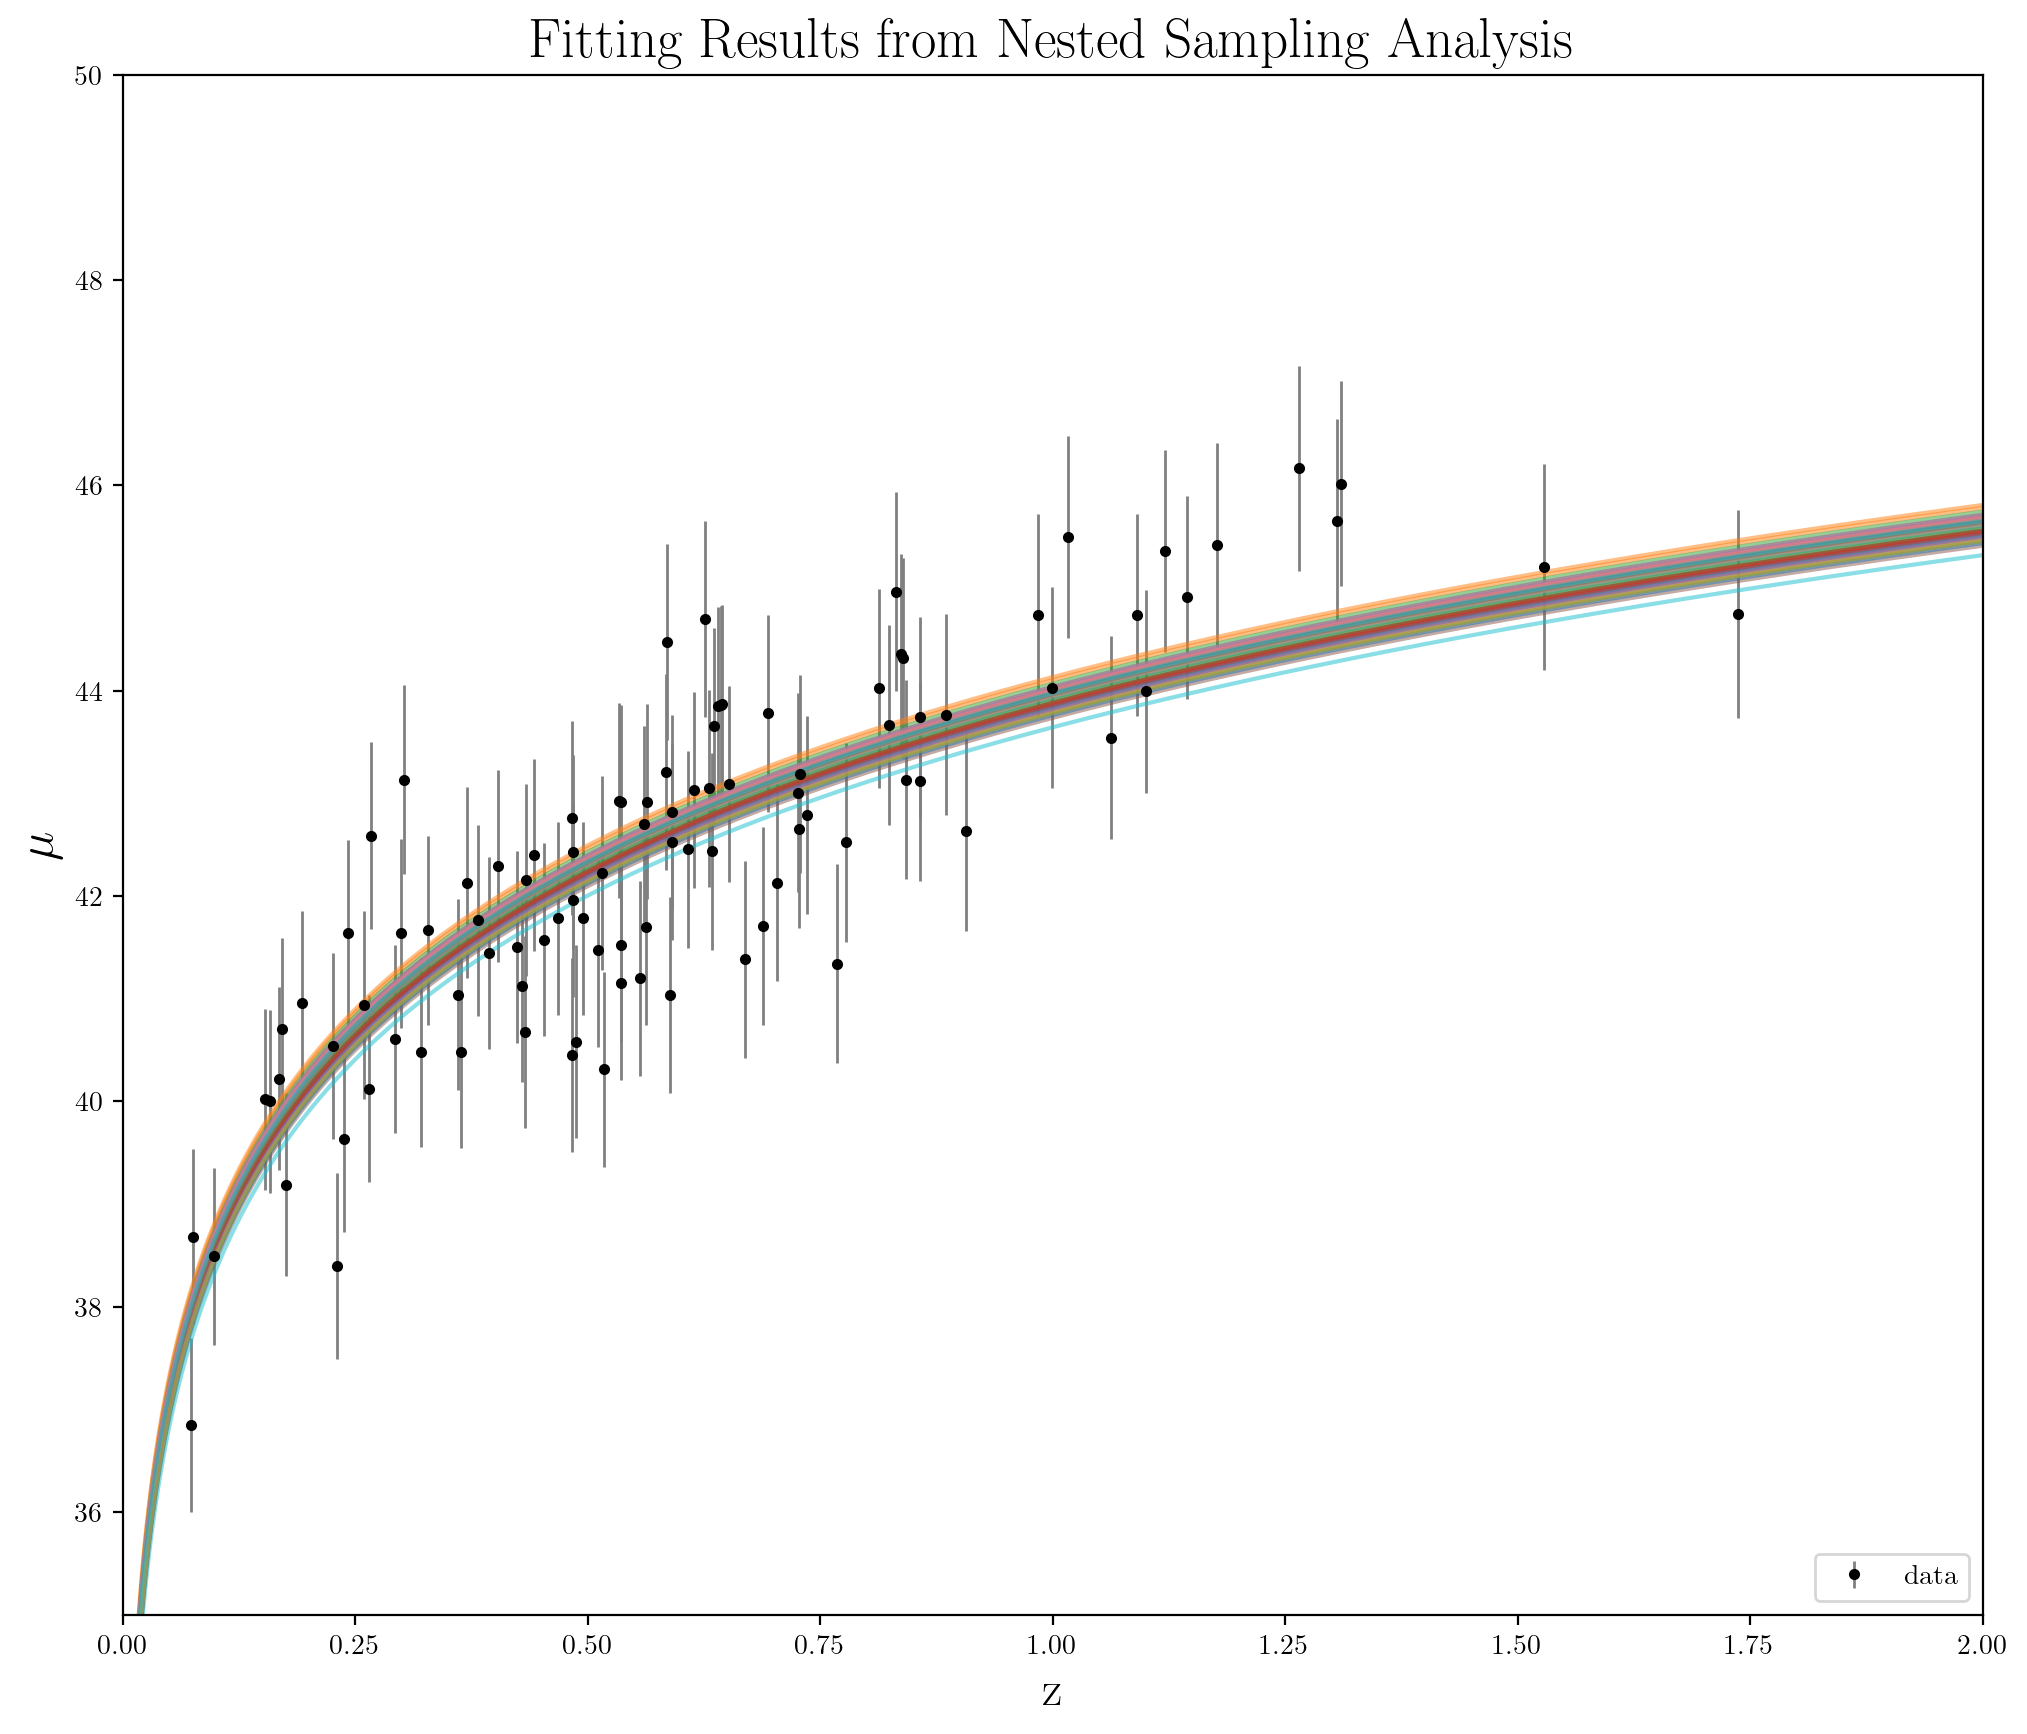

In [75]:
fig = plt.figure(figsize=(12, 10))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

samples_batch_new = np.random.choice(np.arange(0, len(samples_equal_new)), size=50, replace=False)
chosen_samples_new= samples_equal_new[samples_batch_new]

for chosen_par in chosen_samples_new:
    H0 = chosen_par[0]
    ygrid =  mu_cosmology(z_fit, H0, 1)
    plt.plot(z_fit, ygrid, alpha=0.5)
    
plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Fitting Results from Nested Sampling Analysis', fontsize=20)
plt.show()

From a qualitative point of view, so looking by eyes, it doesn't seem to change a lot, but I can compute the evidence and compare

In [77]:
evidence = np.exp(sresults.logz[-1]) #evidence, exp(log of the marginal likeli)
errev = sresults.logzerr[-1] * evidence #with propoag of error rule
print(f"Bayesian evidence of burst model {evidence} ± {errev} ")

evidence_no_de= np.exp(sresults_new.logz[-1]) 
errev_no_de = sresults_new.logzerr[-1] * evidence_no_de
print(f"Bayesian evidence of gaussian model {evidence_no_de} ± {errev_no_de}")

Bayesian evidence of burst model 1.9438443739476085e-59 ± 2.2448851841493731e-60 
Bayesian evidence of gaussian model 9.656774268818774e-60 ± 1.1236238053402556e-60


In [78]:
B_factor = evidence/evidence_no_de
err_B_factor = np.sqrt( errev**2 / evidence_no_de**2 + evidence**2 * errev_no_de**2 / evidence_no_de**2)

In [84]:
print(f'The Bayes Factor (model with DE over model without) is {B_factor:.3f} ± {err_B_factor:.3f} we can say that there is not a strong preference in favour of the first one ')

The Bayes Factor (model with DE over model without) is 2.013 ± 0.232 we can say that there is not a strong preference in favour of the first one 
